# Binning analysis (uniform)

In [7]:
# Statistical analysis library for Monte Carlo Data
import math as m
import numpy as np
import os.path
import sys
import matplotlib.pyplot as plt

In [8]:
#!/usr/bin/python
# pimcstat.py
# Chris Herdman
# 11.30.2012
# 


# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Begin bin function
# -----------------------------------------------------------------------------
# Returns error as a funciton of bin level (D)
# Requires raw Monte Carlo bin data in horizontal rows
# -----------------------------------------------------------------------------
def bindata(MC):
    
    # minimum number of MC bins required
    min_bin = 32

    # initialize B to MC data
    B = MC

    # Resize if 1D array
    if B.ndim == 1:
        B.resize(B.shape[0],1)

    try:
        # Define number of binning levels
        Nl = int(m.floor(m.log(B.shape[0]/min_bin,2))+1)

    except:
        print("Not enough bins. Need {} bins and have {} bins. Setting binning level to 1.".format(min_bin,B.shape[0]))
        Nl = 1

    # initialize D
    D = np.zeros((Nl,B.shape[1]))
    
    # First level of binning is raw data
    D[0,:] = np.std(MC,0)/m.sqrt(B.shape[0]-1)
    
    # Binning loop over levels l
    for l in range(1,Nl):
        
        # Bin pairs of bins: if odd # of bins, truncate first bin
        if ((B.shape[0] % 2) == 0):
            B = (B[::2,:]+ B[1::2,:])/2
        else:
            B = (B[1::2,:]+ B[2::2,:])/2
        
        # Error at level l
        D[l,:] = np.std(B,0)/m.sqrt(B.shape[0]-1)
    
    return D
# -----------------------------------------------------------------------------
# end of bin function
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Begin autocorr function
# -----------------------------------------------------------------------------
# Returns autocorrelation as a funciton of MC update time
# Averages dt over entire MC run, from dt=1 to dt=T/2
# -----------------------------------------------------------------------------
def autocorr(MC):
    
    # Reshape MC to 2D array if column vector
    if MC.ndim == 1:
        MC.resize(MC.shape[0],1)
    
    # Number of MC bins
    T = MC.shape[0]
    
    # Number of AC steps
    Nt = T//2+1
    
    ac = np.zeros((Nt,MC.shape[1]))
    dac = np.zeros((Nt,MC.shape[1]))
    
    A2 = np.average(MC,0)**2
    dA2 = np.sqrt(2*A2)*np.std(MC,0)/np.sqrt(T)
    AA = np.average(MC*MC,0)
    dAA = np.std(MC*MC,0)/np.sqrt(T)
    ac[0,:] = np.ones((1,MC.shape[1]))
    for dt in range(1,Nt):
        AtA0 = MC[:-dt,:]*MC[dt:,:]
        ac[dt,:] = (np.average(AtA0,0)-A2)/(AA-A2)
        dac[dt,:] = np.sqrt( (ac[dt,:]**2)*( \
                    (np.std(AtA0,0)**2/AtA0.shape[0]+dA2**2)/ \
                    (np.average(AtA0,0)-A2)**2 + (dAA**2+dA2**2)/(AA-A2)**2) )
    
    return {'correlation':ac, 'error':dac}
    
# -----------------------------------------------------------------------------
# end of autocorr function
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Begin bin_ac function
# -----------------------------------------------------------------------------
# Returns estimate of autocorrelation time in bins from binning analysis (tau)
# Requires processed bins from bin function
# -----------------------------------------------------------------------------
def bin_ac(D,dD=None):
    
    if D.ndim == 1:
        D.resize((len(D),1))
        if dD is not None:
            dD.resize((len(dD),1))
        
    # initialize autocorrelation time
    tau = np.zeros(D.shape[1])
    dtau = np.zeros(D.shape[1])
    
    #Loop of columns of D to compute tau,CF
    for c in range(D.shape[1]):
        if D[0,c] != 0.0:
            tau[c] = 0.5*((D[-1,c]/D[0,c])**2-1)
            if dD is not None:
                dtau[c] = np.sqrt(tau[c]**2*( (dD[-1,c]/D[-1,c])**2 + \
                                   (dD[0,c]/D[0,c])**2 ) )
            
    return {'tau':tau,'dtau':dtau}
# -----------------------------------------------------------------------------
# end of bin_ac function
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

In [19]:
# Load data
K_SF = np.loadtxt("1D_4_4_2_3.300000_1.000000_4.000000_100_K_1968_square.dat")[2000:]
V_SF = np.loadtxt("1D_4_4_2_3.300000_1.000000_4.000000_100_V_1968_square.dat")[2000:]

In [20]:
# Compute error as a function of bin levelb
binned_K_SF = bindata(K_SF)
binned_V_SF = bindata(V_SF)

In [21]:
print("<K> = %.4f +/- %.4f"%(np.mean(K_SF),binned_K_SF.max()))
print("<V> = %.4f +/- %.4f"%(np.mean(V_SF),binned_V_SF.max()))

<K> = -7.0477 +/- 0.0134
<V> = 2.5470 +/- 0.0099


Text(0.5, 0, 'bin level')

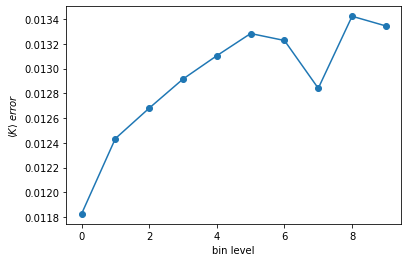

In [22]:
# Plot
plt.plot(binned_K_SF,'-o')
plt.ylabel(r'$\langle K \rangle \; error$')
plt.xlabel('bin level')

Text(0.5, 0, 'bin level')

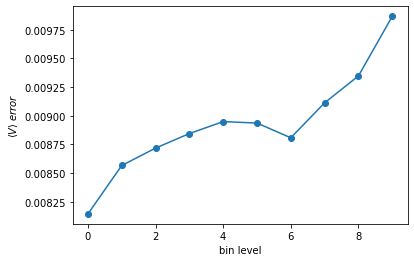

In [23]:
# Plot
plt.plot(binned_V_SF,'-o')
plt.ylabel(r'$\langle V \rangle \; error$')
plt.xlabel('bin level')

In [24]:
0.5*((max(binned_K_SF)/binned_K_SF[0])**2 - 1)

array([0.14405127])

In [25]:
# Estimate autocorrelation times from binned data
bin_ac(binned_K_SF),bin_ac(binned_V_SF)

({'tau': array([0.13654689]), 'dtau': array([0.])},
 {'tau': array([0.23387315]), 'dtau': array([0.])})

In [78]:
# Compute autocorrelation times from MC data
autocorr(K_SF),autocorr(V_SF)

({'correlation': array([[ 1.00000000e+00],
         [ 2.23631209e-01],
         [ 1.82177940e-02],
         ...,
         [-8.34865278e-03],
         [-1.36325392e-04],
         [-4.22975348e-03]]),
  'error': array([[0.        ],
         [0.01861117],
         [0.01333038],
         ...,
         [0.01614654],
         [0.0159768 ],
         [0.01655622]])},
 {'correlation': array([[ 1.        ],
         [ 0.18343623],
         [-0.00246278],
         ...,
         [ 0.00218828],
         [-0.00331877],
         [-0.00331877]]),
  'error': array([[0.        ],
         [0.06953748],
         [0.00105954],
         ...,
         [0.00555008],
         [0.0008185 ],
         [0.0008185 ]])})